# LRP Tutorial for Pretrained VGG16 Model

This notebook demonstrates how to apply the Layer-Wise Relevance Propagation (LRP) algorithm on a pre-trained VGG16 model using a sample image. The relevance of each pixel is visualized by overlaying them on the example image. Further details regarding the operating principles of LRP can be found at [heatmapping.org](http://heatmapping.org/) and [here](https://www.springerprofessional.de/layer-wise-relevance-propagation-an-overview/17153814).

The tutorial uses the same sample image and rule configuration as in [this](https://git.tu-berlin.de/gmontavon/lrp-tutorial) PyTorch implementation.




Note: Before running this tutorial, please install the torchvision and PIL packages.


In [7]:
import torch
from PIL import Image
from torchvision import models, transforms

from captum.attr import LRP
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule

Loads the sample image and performs the appropriate normalizing steps.

In [2]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('img/resnet/swan-3299528_1280.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

Loads pre-trained VGG16 model and sets it to eval mode.

In [ ]:
model = models.vgg16(pretrained=True)
model.eval()

The model must not use inplace ReLU activations, as we need the activations of the single layers for the backpropagation of the activation. So we deactivate the inplace functionality with the following lines.

In [4]:
for module in model.modules():
    if isinstance(module, torch.nn.ReLU):
        module.inplace=False

Direct generation of LRP attribution. The default Epsilon-Rule is used for every layer. As one see in the generated output image, this does not bring many new insights as the heatmap does not focus well on the image content.

/home/jwkuenzel/projects/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


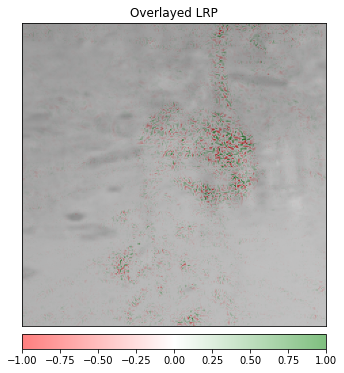

In [13]:
lrp = LRP(model)
attribution = lrp.attribute(input, target=99, verbose=False)  # goose -> 99
attribution = attribution.squeeze().permute(1, 2, 0).detach().numpy()

_ = viz.visualize_image_attr(
    attribution,
    img,
    method='blended_heat_map',
    sign='all',
    show_colorbar=True,
    title='Overlayed LRP',
)

But one can assign different rules to every layer. This is a crucial step to get expressive heatmaps. In the literature, one can find recommendations on when to use which layer. Currently implemented in captum are LRP-Epsilon, LRP-0, LRP-Gamma, LRP-Alpha-Beta, and the Identity-Rule.

In the next steps, a list of all layers is generated and a rule is assigned to each one.

Reference for recommendations on how to set the rules: *Kohlbrenner, M.; Bauer, A.; Nakajima, S.; Binder, A.; Samek, W.; Lapuschkin, S. Towards best practice in explaining neural network decisions with LRP. In Proceedings of the IEEE International Joint Conference on Neural Networks (IJCNN), Glasgow, UK, 19–24 July 2020*

In [10]:
layers = list(model._modules['features']) + list(model._modules['classifier'])
number_layers = len(layers)

for idx_layer in range(1, number_layers)[::-1]:
    if idx_layer <= 16:
        setattr(layers[idx_layer], 'rule', GammaRule())
    if 17 <= idx_layer <= 30:
        setattr(layers[idx_layer], 'rule', EpsilonRule())
    if idx_layer >= 31:
        setattr(layers[idx_layer], 'rule', EpsilonRule(epsilon=0))  # LRP-0

In [ ]:
lrp = LRP(model)
attribution = lrp.attribute(input, target=99, verbose=True)  # goose -> 99
attribution = attribution.squeeze().permute(1, 2, 0).detach().numpy()

_ = viz.visualize_image_attr(
    attribution,
    img,
    method='blended_heat_map',
    sign='all',
    show_colorbar=True,
    title='Overlayed LRP',
)

With the verbose parameter, one can check the correct application of the rules in the generated output. As one can see in the generated output image, the heatmap shows clearly positive attributions for the beak of the swan.